## 2- Trial by Trial Data

Much of what we went over in the first notebook was information for a whole session, or day. But, most of our analyses depend on trial by trial information. In this notebook I'll show you how to access to types of trial information from DJ- **parsed events history** and **protocol data**.

Written by Jess Breda Feburary 2023

### 1. Libararies

In [1]:
import datajoint as dj
dj.blob.use_32bit_dims = True # need this for peh and pd!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

### 2. Parsed Events History

**What is it?** 

Parsed events history (peh) is where all the event timing information for each trial in a session stored. This includes animal actions (poke times) as well as protocol actions (state times, waves). 

**How is it stored?**

In it's native format, it is a series of nested matlab structs. When read into python in this way, it's a nested list of lists of dictionaries. 

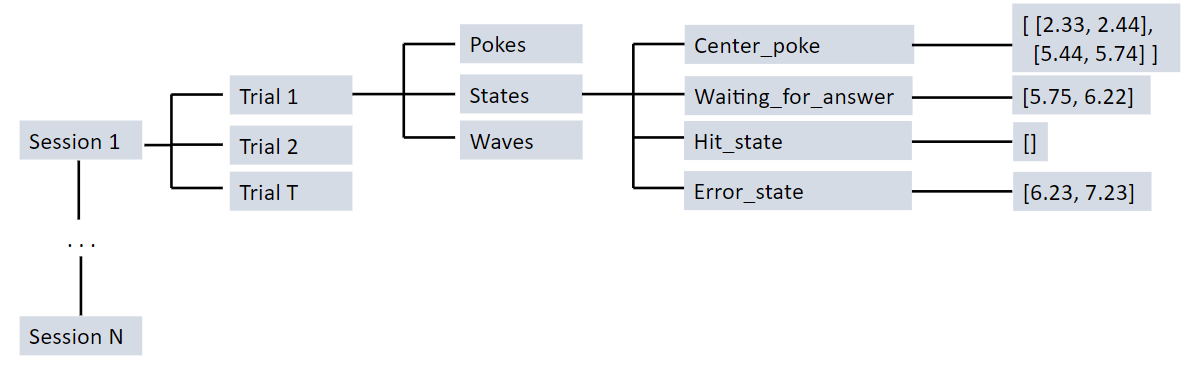

**Why is this sub optimal?**

(1) access nested structures in python is a pain

(2) it's *extremely* slow to read in on DataJoint

**What's the fix?**

The `BehaviorEvent` table which takes (almost) all of the peh info and turns it into a long form pandas DataFrame which is pre-formatted reads and in 5x faster.

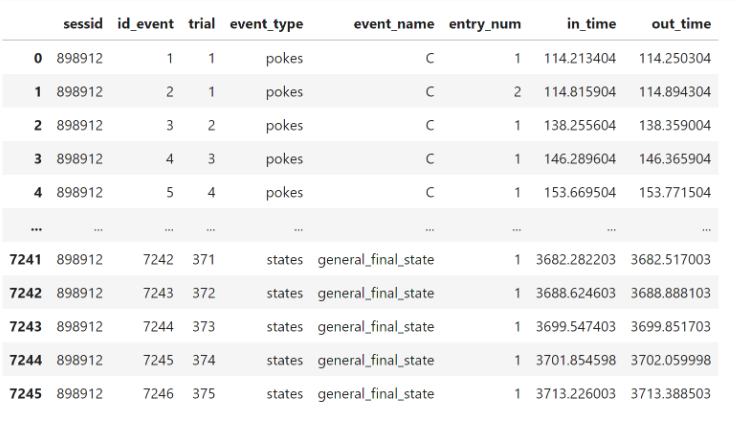


#### 2.1 Read in 

Let's read in the events table for a single session and play around with it.

In [2]:
# __name__ =                    (__name__, schema name)
bdata = dj.create_virtual_module("bdata", "bdata")

print(bdata.BehaviorEvent.describe())

[2023-02-19 15:40:14,021][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2023-02-19 15:40:14,530][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306


-> bdata.Sessions
id_event             : int                          # Unique number for event
---
trial                : int                          # trial number in session
event_type           : varchar(16)                  # type of event in session (e.g. pokes, states)
event_name           : varchar(32)                  # sub category of event type (e.g. C, L, R, state0)
entry_num            : int                          # occurence number of event inside trial
in_time=null         : double                       # start time of event
out_time=null        : double                       # end time of event



In [3]:
SESSION = 898912
key = {'sessid' : SESSION}

df_events = pd.DataFrame((bdata.BehaviorEvent & key).fetch(as_dict=True))

df_events

,sessid,id_event,trial,event_type,event_name,entry_num,in_time,out_time
0,898912,1,1,pokes,C,1,114.213404,114.250304
1,898912,2,1,pokes,C,2,114.815904,114.894304
2,898912,3,2,pokes,C,1,138.255604,138.359004
3,898912,4,3,pokes,C,1,146.289604,146.365904
4,898912,5,4,pokes,C,1,153.669504,153.771504
...,...,...,...,...,...,...,...,...
7241,898912,7242,371,states,general_final_state,1,3682.282203,3682.517003
7242,898912,7243,372,states,general_final_state,1,3688.624603,3688.888103
7243,898912,7244,373,states,general_final_state,1,3699.547403,3699.851703
7244,898912,7245,374,states,general_final_state,1,3701.854598,3702.059998


#### 2.2 Plot Example

### 3. Protocol Data

Protocol Data (pd) is a field in the `bdata.Sessions` table. It's usually created under the `make_and_send_summary` case of the protocol and depending on the protocol you will find differing information. 

I leverage this field in the [`DMS` protocol](https://github.com/Brody-Lab/Protocols/blob/master/%40DMS/HistorySection.m#L429) to save out trial-by-trial information so I can access it all via DataJoint (rather than opening a `_data.mat` file for each session). I highly recommend it and am happy to talk about how to adjust your protocol to do so. 

Here is a key for the way I code DMS protocol data: 

| variable             | values          | key                                                 |
|----------------------|-----------------|-----------------------------------------------------|
| `hit_history`        | [0, 1, NaN]     | [error, hit, violation]                             |
| `temp_error_history` | [0, 1, NaN]     | [no terror, terror, violation]                      |
| `side_history`       | [l, r]          | [left, right]                                       |
| `result_history`     | [1, 2, 3, 4, 5] | [hit, error, violation, terror, crash]              |
| `sa`                 | float           | value of sa in Hz                                   |
| `sb`                 | float           | value of sb in Hz                                   |
| `dms_type`           | [0, 1]          | [nonmatch, match]                                   |
| `delay`              | float           | duration of delay between sa/sb in s                |
| `fixation`           | float           | duration of pre --> go (fixation required or not)   |
| `timeouts`           | float           | duration of timeout in s                            |
| `helper`             | [0, 1]          | if trial was in helper block (not in use currently) |
| `stage`              | float           | stage number                                        |



#### 3.1 Read in

Let's go through the steps of reading in these data for the same session as above and in the next notebook I'll have some code for how I automate & customize this process for my protocol.


In [4]:
bdata = dj.create_virtual_module("bdata", "bdata")

protocol_data_blob = (bdata.Sessions & key).fetch('protocol_data', as_dict=True)

type(protocol_data_blob[0]['protocol_data'])

datajoint.blob.MatStruct

We can't directly read this in as a pandas DataFrame because it's a blob. To be honest, I don't exactly know what blobs are, but I do know that python doesn't really like them. So we need to use some `utility functions to go from **blob -> dict**.

In [5]:
from dj_utils import transform_blob

protocol_data_dict = transform_blob(protocol_data_blob[0]['protocol_data'])

for key,value in protocol_data_dict.items():
    print(f"key: {key} **** entries: {len(value)}")


key: hits **** entries: 375
key: temperror **** entries: 375
key: sides **** entries: 375
key: result **** entries: 375
key: sa **** entries: 375
key: sb **** entries: 375
key: dms_type **** entries: 375
key: delay **** entries: 375
key: fixation **** entries: 375
key: timeouts **** entries: 375
key: helper **** entries: 375
key: stage **** entries: 375


Because all of the items in my DMS protocol data are the same length, I will then convert **dict -> DataFrame**.

In [6]:
from dj_utils import blob_dict_to_df

protocol_df = blob_dict_to_df(protocol_data_dict)

protocol_df

,hits,temperror,sides,result,sa,sb,dms_type,delay,fixation,timeouts,helper,stage
0,1.0,0.0,r,1.0,12000.0,3000.0,0.0,0.2,0.95,NaN,0.0,8.0
1,1.0,0.0,l,1.0,12000.0,12000.0,1.0,0.2,0.95,NaN,0.0,8.0
2,1.0,0.0,l,1.0,12000.0,12000.0,1.0,0.2,0.95,NaN,0.0,8.0
3,1.0,0.0,l,1.0,12000.0,12000.0,1.0,0.2,0.95,NaN,0.0,8.0
4,1.0,0.0,r,1.0,12000.0,3000.0,0.0,0.2,0.95,NaN,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
370,1.0,0.0,l,1.0,12000.0,12000.0,1.0,0.2,0.95,NaN,0.0,8.0
371,1.0,0.0,r,1.0,12000.0,3000.0,0.0,0.2,0.95,NaN,0.0,8.0
372,0.0,0.0,r,2.0,12000.0,3000.0,0.0,0.2,0.95,5.0,0.0,8.0
373,1.0,0.0,r,1.0,12000.0,3000.0,0.0,0.2,0.95,NaN,0.0,8.0


One limitation of this approach that it doesn't do a great job of preserving data types. For example, `hits` is a `float`, but it should be an `int` (either the animal got it correct or not).

To this end, I've written some extra functions to clean up this import and append additional columns that can be found in `pd_to_df.py`. Let's check this out in the next notebook.